##Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# %rest

import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

# Load the traffic signs data 
training_file = 'traffic_signs_data/train.p'
validation_file = 'traffic_signs_data/valid.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
img_train, y_train = train['features'], train['labels']
img_valid, y_valid = valid['features'], valid['labels']
img_test, y_test = test['features'], test['labels']

assert img_train.shape[0] == len(y_train)
assert img_valid.shape[0] == len(y_valid)
assert img_test.shape[0]  == len(y_test)

print('img_train:', img_train.shape)
print('img_valid:', img_valid.shape)
print('img_test: ', img_test.shape)

img_train: (34799, 32, 32, 3)
img_valid: (4410, 32, 32, 3)
img_test:  (12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Finding number of examples for each case

# Number of training examples
n_train = img_train.shape[0]

# Number of validationi examples
n_valid = img_valid.shape[0]

# Number of testing examples.
n_test = img_test.shape[0]
# The shape of an traffic sign image
image_shape = img_train.shape[1:]

# Number of unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

Original training images:


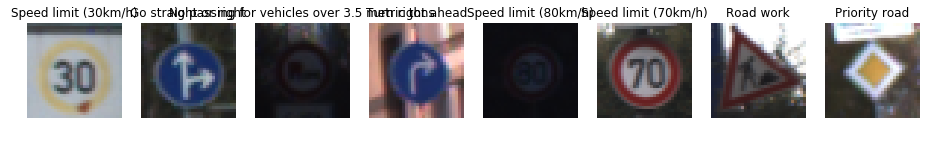

In [3]:
### read signnames.cvs and put all labels and sign names into a dictionary
import csv
from itertools import islice

sign_names = {}
with open('signnames.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in islice(reader, 1, None): # skip the first line
        sign_names[row[0]] = row[1]
        
### Data exploration visualization        
n_plots = 8
rand_idx = np.random.choice(n_train, n_plots) 
print('Original training images:')

fig, ax = plt.subplots(1, n_plots, figsize=(16,16))
for i in range(n_plots):
    ax[i].imshow(img_train[rand_idx[i],:,:,:])
    ax[i].set_title(sign_names[str(y_train[rand_idx[i]])])
    ax[i].axis('off')
plt.show()
# plt.savefig('results/train_samples.png', bbox_inches='tight')

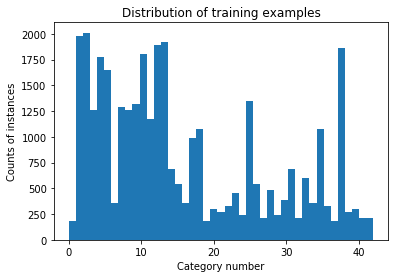

In [4]:
# Displaying number of samples in each class
plt.hist(y_train, bins = n_classes)
plt.xlabel('Category number')
plt.ylabel('Counts of instances')
plt.title('Distribution of training examples')
plt.show()
# plt.savefig('results/label_hist.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
### Preprocess the data here. 
# First convert to grayscale then normalize the pixels

def rgb2gray(X):
    """
    Convert RGB color image to gray-scale
    :param X: Color image 
    :return: Gray-scale image
    """
    result = np.zeros((X.shape[0], X.shape[1], X.shape[2], 1))
    result[:,:,:,0] = 0.299 * X[:,:,:,0] + 0.587 * X[:,:,:,1] + 0.114 * X[:,:,:,2]
    return result
    
    
def normalize(X, a=0, b=1):
    """
    Normalize the image data with Min-Max scaling to a range of [a,b]
    :param X: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    Xmax = X.max()
    Xmin = X.min()
    return a + (b-a)* (X - Xmin) / (Xmax - Xmin)

Original color images:


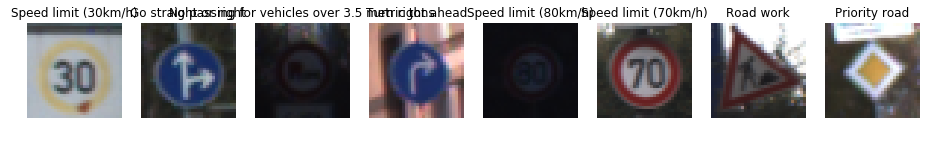

Normalized gray-scale images:


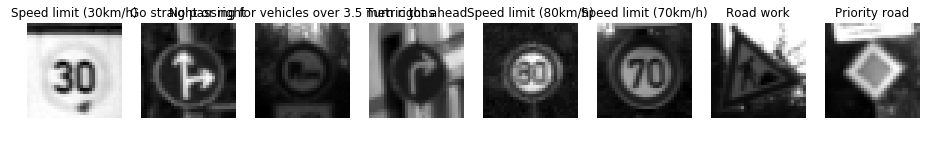

In [6]:
X_train_norm = normalize(rgb2gray(img_train))
X_valid_norm = normalize(rgb2gray(img_valid))
X_test_norm = normalize(rgb2gray(img_test))

# Displaying original and normalized images
print('Original color images:')
fig, ax1 = plt.subplots(1, n_plots, figsize=(16,16))
for i in range(n_plots):
    ax1[i].imshow(img_train[rand_idx[i],:,:,:])
    ax1[i].set_title(sign_names[str(y_train[rand_idx[i]])])
    ax1[i].axis('off')
plt.show()

print('Normalized gray-scale images:')
fig, ax2 = plt.subplots(1, n_plots, figsize=(16,16))
for i in range(n_plots):
    ax2[i].imshow(X_train_norm[rand_idx[i],:,:,0], cmap = 'gray')
    ax2[i].set_title(sign_names[str(y_train[rand_idx[i]])])
    ax2[i].axis('off')
plt.show()
# plt.savefig('results/train_samples_grayscale.png', bbox_inches='tight')

### Model Architecture

In [7]:
### Define main architecture of the convolution network

import tensorflow as tf

# tf.reset_default_graph()

def weight_variable(size):
    return tf.Variable(tf.truncated_normal(size, mean=0, stddev=0.1))

def bias_variable(size):
    return tf.Variable(tf.zeros(size))

# main architecture of the network
def conv_neural_net(x):    
    
    weights = {'c1': weight_variable([5,5,1,6]),
               'c2': weight_variable([5,5,6,12]),
               'f1': weight_variable([300,150]),
               'f2': weight_variable([150,84]),
               'out': weight_variable([84,n_classes])}

    biases = {'c1': bias_variable([6]),
              'c2': bias_variable([12]),
              'f1': bias_variable([150]),
              'f2': bias_variable([84]),
              'out': bias_variable([n_classes])}
    
    # Layer 1
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer_c1 = tf.nn.conv2d(x, weights['c1'], [1,1,1,1], 'VALID') + biases['c1']
    # Activation.
    layer_c1 = tf.nn.relu(layer_c1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    layer_s1 = tf.nn.max_pool(layer_c1, [1,2,2,1], [1,2,2,1], 'VALID') 
    
    # Layer 2
    # Convolutional. Output = 10x10x12.
    layer_c2 = tf.nn.conv2d(layer_s1, weights['c2'], [1,1,1,1], 'VALID') + biases['c2']
    # Activation.
    layer_c2 = tf.nn.relu(layer_c2)
    # Pooling. Input = 10x10x12. Output = 5x5x12.
    layer_s2 = tf.nn.max_pool(layer_c2, [1,2,2,1], [1,2,2,1], 'VALID')

    # Flatten. Input = 5x5x16. Output = 300.
    features = tf.contrib.layers.flatten(layer_s2)
    
    # Layer 3
    # Fully Connected. Input = 300. Output = 150.
    layer_f1 = tf.matmul(features, weights['f1']) + biases['f1']
    # Activation.
    layer_f1 = tf.nn.relu(layer_f1)

    # Layer 4
    # Fully Connected. Input = 150. Output = 84.
    layer_f2 = tf.matmul(layer_f1, weights['f2']) + biases['f2']
    # Activation.
    layer_f2 = tf.nn.relu(layer_f2)

    # Layer 5
    # Fully Connected. Input = 84. Output = 43.
    logits = tf.matmul(layer_f2, weights['out']) + biases['out']
    
    activations = [layer_c1, layer_s1, layer_c2, layer_s2]
    
    return logits, layer_c1, layer_s1, layer_c2, layer_s2

In [8]:
alpha = 0.001  # learning rate

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits, layer_c1, layer_s1, layer_c2, layer_s2 = conv_neural_net(x)

# compute cross entropy of logits and labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

# AdamOptimizer for optimization 
optimizer = tf.train.AdamOptimizer(alpha)
training_operation = optimizer.minimize(loss_operation)

In [9]:
# Prediction accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data):
    n_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, n_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / n_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [10]:
### Train the model.
### Calculate and report the accuracy on the training and validation set.


import sklearn

EPOCHS = 50
BATCH_SIZE = 128

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_examples = len(X_train_norm)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        Xshuffle, yshuffle = sklearn.utils.shuffle(X_train_norm, y_train)
        for offset in range(0, n_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = Xshuffle[offset:end], yshuffle[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        #%time accuracy_train = evaluate(Xshuffle, yshuffle)
        accuracy_valid = evaluate(X_valid_norm, y_valid)
        
        if not (i+1)%5:
            print("EPOCH {} ...".format(i+1))
            #print("Training Accuracy   = {:.3f}%".format(accuracy_train*100))
            print("Validation Accuracy = {:.3f}%".format(accuracy_valid*100))
            print()
        
    saver.save(sess, './project2')
    print("Training done. Model saved!")

Training...

EPOCH 5 ...
Validation Accuracy = 86.757%

EPOCH 10 ...
Validation Accuracy = 89.932%

EPOCH 15 ...
Validation Accuracy = 91.224%

EPOCH 20 ...
Validation Accuracy = 90.317%

EPOCH 25 ...
Validation Accuracy = 90.181%

EPOCH 30 ...
Validation Accuracy = 90.635%

EPOCH 35 ...
Validation Accuracy = 91.202%

EPOCH 40 ...
Validation Accuracy = 91.429%

EPOCH 45 ...
Validation Accuracy = 92.948%

EPOCH 50 ...
Validation Accuracy = 92.902%

Training done. Model saved!


In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    %time accuracy_train = evaluate(Xshuffle, yshuffle)
    print("Training Accuracy   = {:.3f}%".format(accuracy_train*100))

CPU times: user 21.3 s, sys: 1.76 s, total: 23.1 s
Wall time: 6.48 s
Training Accuracy   = 100.000%



In [11]:
### After the model is fine tuned, calculate the accuracy on the test set.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}%".format(test_accuracy*100))

Test Accuracy = 91.813%


---

## Step 3: Test a Model on New Images

For more insight into how the model is working, external images are used for testing.

### Load and Output the Images

In [12]:
import os
test_images = os.listdir("test_images/")
test_images

['children_crossing.jpg',
 'no_vehicles.jpg',
 'stop.jpg',
 'bumpy_road.jpg',
 'speed_limit_60.jpg',
 'yield.jpg',
 'speed_limit_50.jpg',
 'road_work.jpg',
 'general_caution.jpg']

Test images from the web:


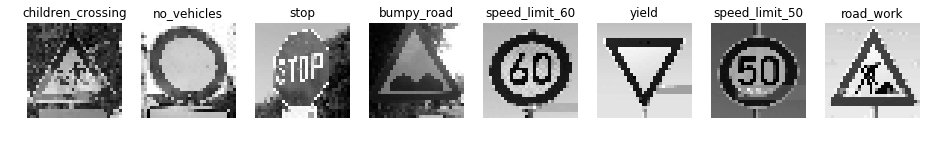

In [13]:
### Load the test images, resize them into (32,32), convert to grayscale, and plot them.

import os
test_images = os.listdir("test_images/")

import cv2
im_resize = np.zeros([32,32])
im_test = np.zeros((len(test_images),32,32,1))

for i,name in enumerate(test_images):
    im_raw = mpimg.imread('test_images/'+ name)
    im_resize = cv2.resize(im_raw, (32,32))
    im_gray = cv2.cvtColor(im_resize, cv2.COLOR_BGR2GRAY)
    im_test[i,:,:,0] = im_gray


print('Test images from the web:')
fig, ax2 = plt.subplots(1, n_plots, figsize=(16,16))
for i in range(n_plots):
    ax2[i].imshow(im_test[i,:,:,0], cmap = 'gray')
    ax2[i].set_title(str(test_images[i].split('.')[0]))
    ax2[i].axis('off')
plt.show()

### Predict the Sign Type for Each Image

In [14]:
### Run the predictions and print the prediction for each image.
prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = sess.run(prediction, feed_dict={x:im_test})

for i,label in enumerate(pred):
    line_new = 'Truth: {:20} Prediction: {}'.format(test_images[i].split('.')[0], sign_names[str(label)])
    print(line_new)

Truth: children_crossing    Prediction: Children crossing
Truth: no_vehicles          Prediction: No vehicles
Truth: stop                 Prediction: Yield
Truth: bumpy_road           Prediction: Turn left ahead
Truth: speed_limit_60       Prediction: Speed limit (60km/h)
Truth: yield                Prediction: Yield
Truth: speed_limit_50       Prediction: Speed limit (50km/h)
Truth: road_work            Prediction: Road work
Truth: general_caution      Prediction: General caution


### Analyze Performance

In [15]:
### Calculate the accuracy for these 9 new images. 
label_test = [28,15,14,22,3,13,2,25,18]
correct_pred = tf.equal(pred, label_test)
get_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


with tf.Session() as sess:
    accuracy = sess.run(get_accuracy)
    
print('Accuracy with {} test images: {:.3f}%'.format(len(label_test), accuracy*100))


Accuracy with 9 test images: 77.778%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [16]:
### Print out the top 5 softmax probabilities for the predictions on the
### German traffic sign images found on the web. 
softmax_prob = tf.nn.softmax(logits)
get_top5 = tf.nn.top_k(softmax_prob, k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5 = sess.run(get_top5, feed_dict={x:im_test})
    
# print(logits)
print(top5)


TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[28,  0,  1,  2,  3],
       [15,  0,  1,  2,  3],
       [13,  0,  1,  2,  3],
       [34,  0,  1,  2,  3],
       [ 3,  0,  1,  2,  4],
       [13,  0,  1,  2,  3],
       [ 2,  0,  1,  3,  4],
       [25,  0,  1,  2,  3],
       [18,  0,  1,  2,  3]], dtype=int32))


---

## Step 4: Visualize the Neural Network's State with Test Images

 While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [17]:
### Visualize the network's feature maps.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: a tf variable name used during your training procedure that represents the
# calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot 
# sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend
# the plt number for each new feature map entry

def output_feature_map(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess the image_input in a way the network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable
    # from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest",
                       vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest",
                       vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", 
                       vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Feature map C1...


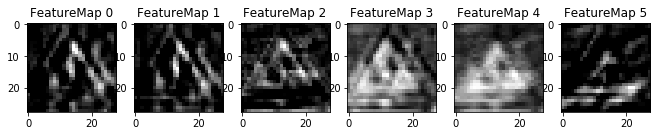

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
#     new_saver = tf.train.import_meta_graph('project2.meta')
#     new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print('Feature map C1...')
    output_feature_map(im_test, layer_c1) 

Feature map S1...


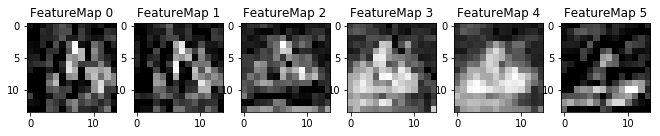

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print('Feature map S1...')
    output_feature_map(im_test, layer_s1) 

Feature map C2...


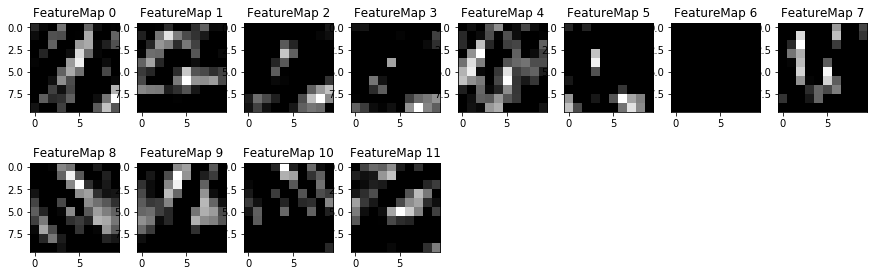

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print('Feature map C2...')
    output_feature_map(im_test, layer_c2) 
   

Feature map S2...


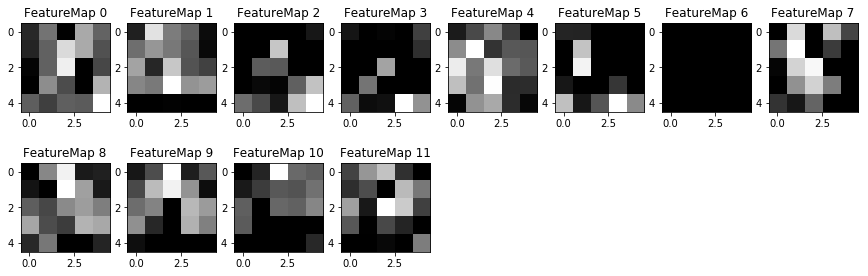

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print('Feature map S2...')
    output_feature_map(im_test, layer_s2) 

**Discussion:**

In layer C1, the feature map picks up main edges of the input image. Each feature map detected edges of different orientations, in combination all the feature maps learned the main shape of the traffic sign - a triangle. Layer S1 feature maps are down-sampled version of C1 feature maps. Layer C2 neurons fires in a geometric shape very similar to the grayscale input image. Layer S2 is a down-sampled version of layer C2 features.